### Overview

This first pass will include standard linear regression models (regular, lasso, ridge, and elasticnet). However, we will keep the preprocessing steps simple by just transforming skewed variables. Whichever model has the lowest RMSE will be submitted as a first pass.

Further iterations will include more advanced variable selection and feature engineering.

### Load Data and Important Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in the data
train = pd.read_csv("train.csv", index_col = 0)
test = pd.read_csv("test.csv", index_col = 0)

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# concatenate the data together
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))
print all_data.shape


(2919, 79)


In [4]:
# Because the target variable is skewed, take the log of it
train["SalePrice"] = np.log(train["SalePrice"])

In [5]:
# Check which columns have a lot of NA's in training data

print "Numeric Variables:"
list_feature_Nan = []
for i in train.select_dtypes(exclude=['object']).columns:
    if (train[i].isnull()).astype(int).sum() > 0:
        print i, "has", round(((train[i].isnull()).astype(int).sum()/1460.0)*100), "% of NaN"
        list_feature_Nan.append(i)
print

print "Categorical Variables:"
for i in train.select_dtypes(include=['object']).columns:
    if (train[i].isnull()).astype(int).sum() > 0:
        print i, "has", round(((train[i].isnull()).astype(int).sum()/1460.0)*100), "% of NaN"

Numeric Variables:
LotFrontage has 18.0 % of NaN
MasVnrArea has 1.0 % of NaN
GarageYrBlt has 6.0 % of NaN

Categorical Variables:
Alley has 94.0 % of NaN
MasVnrType has 1.0 % of NaN
BsmtQual has 3.0 % of NaN
BsmtCond has 3.0 % of NaN
BsmtExposure has 3.0 % of NaN
BsmtFinType1 has 3.0 % of NaN
BsmtFinType2 has 3.0 % of NaN
Electrical has 0.0 % of NaN
FireplaceQu has 47.0 % of NaN
GarageType has 6.0 % of NaN
GarageFinish has 6.0 % of NaN
GarageQual has 6.0 % of NaN
GarageCond has 6.0 % of NaN
PoolQC has 100.0 % of NaN
Fence has 81.0 % of NaN
MiscFeature has 96.0 % of NaN


In [6]:
# Define variable list for numeric variables and categorical variables for later preprocessing
# Categorical variables
non_num_cat_vars = ["MSSubclass"]
cat_vars = train.select_dtypes(include=['object']).columns.tolist()
cat_vars.append(non_num_cat_vars)

# numerical variables
num_vars = train.select_dtypes(exclude=['object']).columns.tolist()
num_vars.remove("SalePrice")

In [7]:
from scipy.stats import skew

# Find all numeric variables that are skewed and transform them

# Compute skewness
skewed_vars = train[num_vars].apply(lambda x: skew(x.dropna()))
skewed_vars = skewed_vars[skewed_vars > 0.75]
skewed_vars = skewed_vars.index

all_data[skewed_vars] = np.log1p(all_data[skewed_vars])

In [8]:
# from sklearn.preprocessing import scale

# For numeric variables, Impute missing values with mean
all_data[num_vars] = all_data[num_vars].fillna(all_data[num_vars].mean())

# Standardize the numeric variables
# all_data[num_vars] = all_data[num_vars].apply(lambda x: (x - np.mean(x)) / np.std(x)) <-- can do this with LinearRegression()

In [9]:
# Get dummy variables for all categorical variables
all_data = pd.get_dummies(all_data)

In [10]:
# Set up data for modeling
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [12]:
# Test out generic LinearRegression to get baseline RMSLE
from sklearn.linear_model import LinearRegression

regr = LinearRegression(normalize = True)
print compute_cv(regr)
print "Avg RMSLE: %f" % compute_cv(regr).mean()

[ 2.22494888  3.57858878  2.06443054  2.79379636  2.91061589]
Avg RMSLE: 2.714476


In [85]:
# Test out Lasso Regression with different values of lambda
from sklearn.linear_model import Lasso
from sklearn.grid_search import GridSearchCV

lasso_params = {"alpha":[0.001, 0.01, 0.05, 0.25, 0.5, 1, 2, 5]}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, lasso_params, scoring="mean_squared_error", n_jobs=-1, cv=5, verbose=1)

lasso_result = lasso_grid.fit(X_train,y)
lasso_result.grid_scores_, lasso_result.best_params_, lasso_result.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.4s finished


([mean: -0.01568, std: 0.00400, params: {'alpha': 0.001},
  mean: -0.02385, std: 0.00435, params: {'alpha': 0.01},
  mean: -0.03399, std: 0.00410, params: {'alpha': 0.05},
  mean: -0.06946, std: 0.00592, params: {'alpha': 0.25},
  mean: -0.07001, std: 0.00569, params: {'alpha': 0.5},
  mean: -0.07204, std: 0.00557, params: {'alpha': 1},
  mean: -0.08013, std: 0.00627, params: {'alpha': 2},
  mean: -0.09304, std: 0.00655, params: {'alpha': 5}],
 {'alpha': 0.001},
 -0.015677777287533261)

In [86]:
from sklearn.tree import RandomForestRegressor

ImportError: cannot import name RandomForestRegressor

### Tune Gradient Boosting Regressor

We will tune this GBRegressor in multiple steps:

1. Number of trees
2. Max_depth and Min_Samples_Split
3. Min_Samples_leaf
4. Max_features
5. Subsample

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
# Tune Session 1: Number of Estimators
param_test1 = {'n_estimators':range(225,276,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=10,min_samples_leaf=10,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test1, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)
gsearch1.grid_scores_, gsearch1.best_params_,gsearch1.best_score_

([mean: -0.01668, std: 0.00277, params: {'n_estimators': 225},
  mean: -0.01667, std: 0.00275, params: {'n_estimators': 235},
  mean: -0.01668, std: 0.00275, params: {'n_estimators': 245},
  mean: -0.01669, std: 0.00274, params: {'n_estimators': 255},
  mean: -0.01663, std: 0.00270, params: {'n_estimators': 265},
  mean: -0.01665, std: 0.00270, params: {'n_estimators': 275}],
 {'n_estimators': 265},
 -0.016627827817101534)

In [50]:
# Tune Session 2: Max_Depth and Min_Sample_Split

param_test2 = {'max_depth':range(6,12,2), 'min_samples_split':range(10,51,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=265, max_features='sqrt', subsample=0.8, random_state=10), param_grid = param_test2, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.01692, std: 0.00340, params: {'min_samples_split': 10, 'max_depth': 6},
  mean: -0.01650, std: 0.00348, params: {'min_samples_split': 20, 'max_depth': 6},
  mean: -0.01564, std: 0.00287, params: {'min_samples_split': 30, 'max_depth': 6},
  mean: -0.01618, std: 0.00303, params: {'min_samples_split': 40, 'max_depth': 6},
  mean: -0.01585, std: 0.00266, params: {'min_samples_split': 50, 'max_depth': 6},
  mean: -0.01733, std: 0.00273, params: {'min_samples_split': 10, 'max_depth': 8},
  mean: -0.01683, std: 0.00300, params: {'min_samples_split': 20, 'max_depth': 8},
  mean: -0.01658, std: 0.00365, params: {'min_samples_split': 30, 'max_depth': 8},
  mean: -0.01646, std: 0.00272, params: {'min_samples_split': 40, 'max_depth': 8},
  mean: -0.01599, std: 0.00283, params: {'min_samples_split': 50, 'max_depth': 8},
  mean: -0.01863, std: 0.00373, params: {'min_samples_split': 10, 'max_depth': 10},
  mean: -0.01767, std: 0.00342, params: {'min_samples_split': 20, 'max_depth': 10},
  

In [53]:
# Tune Session 3: min_sample_leaf

param_test3 = {'min_samples_leaf':range(15,26,2)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=265,max_depth=6,max_features='sqrt', min_samples_split=30,subsample=0.8, random_state=10),param_grid = param_test3, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.01676, std: 0.00194, params: {'min_samples_leaf': 15},
  mean: -0.01661, std: 0.00266, params: {'min_samples_leaf': 17},
  mean: -0.01684, std: 0.00216, params: {'min_samples_leaf': 19},
  mean: -0.01653, std: 0.00237, params: {'min_samples_leaf': 21},
  mean: -0.01687, std: 0.00264, params: {'min_samples_leaf': 23},
  mean: -0.01644, std: 0.00282, params: {'min_samples_leaf': 25}],
 {'min_samples_leaf': 25},
 -0.016438965319804998)

In [59]:
# Tune Session 4: Max_features

param_test4 = {'max_features':range(35,46,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=265,max_depth=6, min_samples_split=30, min_samples_leaf=25, subsample=0.8, random_state=10),param_grid = param_test4, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.01616, std: 0.00277, params: {'max_features': 35},
  mean: -0.01611, std: 0.00259, params: {'max_features': 37},
  mean: -0.01591, std: 0.00278, params: {'max_features': 39},
  mean: -0.01578, std: 0.00266, params: {'max_features': 41},
  mean: -0.01662, std: 0.00294, params: {'max_features': 43},
  mean: -0.01644, std: 0.00295, params: {'max_features': 45}],
 {'max_features': 41},
 -0.015778962270248297)

In [60]:
# Tune Session 5: Subsample

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=265,max_depth=6,min_samples_split=30, min_samples_leaf=25, subsample=0.8, random_state=10,max_features=41),param_grid = param_test5, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.01690, std: 0.00236, params: {'subsample': 0.6},
  mean: -0.01653, std: 0.00229, params: {'subsample': 0.7},
  mean: -0.01624, std: 0.00195, params: {'subsample': 0.75},
  mean: -0.01578, std: 0.00266, params: {'subsample': 0.8},
  mean: -0.01626, std: 0.00205, params: {'subsample': 0.85},
  mean: -0.01605, std: 0.00265, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 -0.015778962270248297)

Optimal Tuning Variables:

Max Depth: 6
Min_Sample_Split: 30
Min_Sample_Leaf: 25
Max_Features: 41
Subsample: 0.8

### Tune Learning Rate

In [61]:
from sklearn.cross_validation import cross_val_score

In [77]:
# Half the learning rate, double the trees

gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=500,max_depth=6, min_samples_split=30, min_samples_leaf=25, subsample=0.8, random_state=10, max_features=41,warm_start=True)

gbm_cv_1 = cross_val_score(estimator=gbm_tuned_1,X = X_train, y=y, scoring="mean_squared_error", cv = 5)
print gbm_cv_1
print gbm_cv_1.mean()

[-0.01261719 -0.01762641 -0.01774777 -0.01274797 -0.01522808]
-0.0151934836358


In [66]:
# Learning Rate = 0.01, n_estimators = 750

gbm_tuned_2 = GradientBoostingRegressor(learning_rate=0.01, n_estimators=750,max_depth=6, min_samples_split=30, min_samples_leaf=25, subsample=0.8, random_state=10, max_features=41,warm_start=True)

gbm_cv_2 = cross_val_score(estimator=gbm_tuned_2,X = X_train, y=y, scoring="mean_squared_error", cv = 5)
print gbm_cv_2
print gbm_cv_2.mean()

[-0.01187439 -0.01920822 -0.01760021 -0.0128868  -0.01651534]
-0.0156169944846


The SD of the cv scores seems very high, so this is probably overfit.

In [69]:
# Try a lower learning rate

gbm_tuned_3 = GradientBoostingRegressor(learning_rate=0.001, n_estimators=1000,max_depth=6, min_samples_split=30, min_samples_leaf=25, subsample=0.8, random_state=10, max_features=41,warm_start=True)

gbm_cv_3 = cross_val_score(estimator=gbm_tuned_3,X = X_train, y=y, scoring="mean_squared_error", cv = 5)
print gbm_cv_3
print gbm_cv_3.mean()

[-0.0420404  -0.05652644 -0.05588453 -0.04457234 -0.04701671]
-0.0492080833945


CV goes way down so this is definitely overfitting.

In [78]:
# Use gbm_tuned_1 for submission

gbm_tuned_1.fit(X_train, y)
preds = np.expm1(gbm_tuned_1.predict(X_test))
submission_gbm1 = pd.DataFrame(data = {'Id':X_test.index.values,'SalePrice':preds})

In [80]:
# Write to csv
submission_gbm1.to_csv("submission_gbm1.csv", index = False)

Scored .1255 on public leaderboard

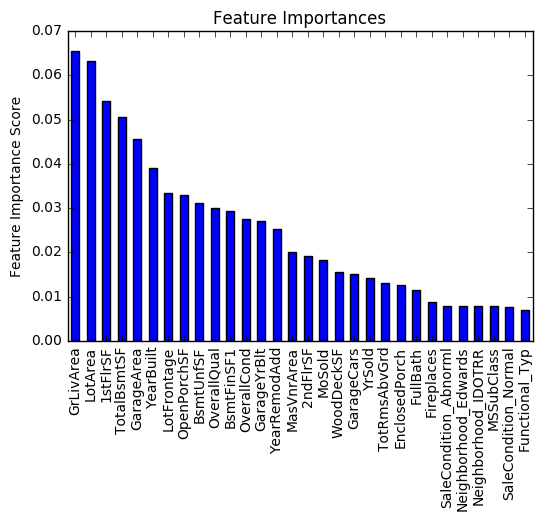

In [84]:
feat_imp = pd.Series(gbm_tuned_1.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp[:30].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()